In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [30]:
df = pd.read_csv("GeneratedXAUUSD dbot.csv")


In [31]:
df.head()

,Time,Open,High,Low,Close,Tick Volume
0,1.396483e+09,1286.69,1289.01,1281.55,1286.34,49277.0
1,1.396570e+09,1286.86,1306.70,1284.17,1302.66,91423.0
2,1.396829e+09,1303.65,1304.02,1295.52,1296.84,28762.0
3,1.396915e+09,1295.79,1314.28,1295.79,1308.31,29838.0
4,1.397002e+09,1308.14,1314.99,1300.80,1311.51,32383.0


In [32]:
# Change the position of the 'B' column
df = df[['Open','Close', 'High','Low','Tick Volume']]
df.tail()

,Open,Close,High,Low,Tick Volume
96401,2070.33,2064.79,2070.63,2063.95,17931.0
96402,2064.74,2059.29,2065.19,2055.82,22342.0
96403,2059.28,2065.39,2067.55,2059.12,16918.0
96404,2065.39,2066.04,2066.86,2064.08,8295.0
96405,2066.02,2065.76,2066.89,2065.26,3181.0


In [33]:
x = df.values
print(x)

[[ 1286.69  1286.34  1289.01  1281.55 49277.  ]
 [ 1286.86  1302.66  1306.7   1284.17 91423.  ]
 [ 1303.65  1296.84  1304.02  1295.52 28762.  ]
 ...
 [ 2059.28  2065.39  2067.55  2059.12 16918.  ]
 [ 2065.39  2066.04  2066.86  2064.08  8295.  ]
 [ 2066.02  2065.76  2066.89  2065.26  3181.  ]]


In [34]:
closing_prices = x[:,1:2]
closing_prices = closing_prices.reshape(-1)
print(closing_prices[-200:])

[2063.29 2064.   2064.68 2063.91 2063.9  2063.97 2064.02 2063.9  2062.75
 2064.26 2063.99 2063.7  2064.22 2063.8  2061.39 2061.91 2061.84 2062.32
 2063.77 2063.57 2063.48 2062.47 2061.72 2062.02 2058.68 2060.58 2057.
 2057.79 2056.73 2058.71 2059.44 2058.91 2057.63 2058.68 2058.23 2060.19
 2061.62 2063.81 2068.33 2067.41 2067.71 2066.33 2066.09 2064.68 2065.46
 2066.33 2066.6  2065.29 2065.24 2066.19 2064.45 2064.45 2065.79 2065.7
 2064.6  2066.44 2065.02 2065.75 2065.95 2066.99 2067.31 2068.53 2068.25
 2063.73 2064.64 2067.4  2068.08 2068.98 2067.6  2067.35 2068.22 2068.92
 2070.2  2077.02 2078.85 2080.43 2081.6  2080.79 2081.8  2081.69 2078.39
 2077.06 2077.45 2076.71 2078.1  2076.65 2077.5  2078.54 2079.44 2079.98
 2079.73 2083.89 2086.98 2086.48 2087.94 2086.05 2087.17 2086.68 2086.49
 2087.31 2085.74 2084.84 2085.76 2085.64 2086.07 2077.43 2077.33 2074.82
 2076.92 2078.06 2077.18 2077.36 2075.41 2074.85 2076.45 2076.61 2072.91
 2075.16 2078.85 2079.69 2077.18 2075.46 2074.14 2075.

In [35]:
def trend_signals(closing_prices, min_gap=3):
  """
  This function analyzes an array of closing prices and generates an array
  with trend start and end signals, requiring a minimum gap of 5 between changes.

  Args:
      closing_prices: A NumPy array of closing prices.
      min_gap: The minimum number of neutral (0) values required between trend changes (default: 5).

  Returns:
      A NumPy array of trend signals with the following meanings:
      0: Neutral, no trend detected.
      1: Start of an uptrend.
      2: Start of a downtrend.
      3: End of both uptrend and downtrend.
  """

  signals = np.zeros(len(closing_prices), dtype=int)
  signals = list(signals)
  current_trend = 0  # 0: Neutral, 1: Uptrend, 2: Downtrend
  neutral_counter = 0

  for i in range(1, len(closing_prices)):
    previous_close = closing_prices[i-1]
    current_close = closing_prices[i]

    if current_trend == 0:
      # Check for uptrend start
      if current_close > previous_close:
        neutral_counter = 0
        signals[i] = 1
        current_trend = 1
      # Check for downtrend start
      elif current_close < previous_close:
        neutral_counter = 0
        signals[i] = 2
        current_trend = 2
    elif current_trend == 1:
      # Check for downtrend within uptrend
      if current_close < previous_close:
        if neutral_counter >= min_gap:
          # Mark end of previous uptrend
          signals[i-1] = 3
          # Start of downtrend
          signals[i] = 2
          current_trend = 2
          neutral_counter = 0
        else:
          # Not enough neutrals, remain in uptrend
          neutral_counter += 1
    elif current_trend == 2:
      # Check for uptrend within downtrend
      if current_close > previous_close:
        if neutral_counter >= min_gap:
          # Mark end of previous downtrend
          signals[i-1] = 3
          # Start of uptrend
          signals[i] = 1
          current_trend = 1
          neutral_counter = 0
        else:
          # Not enough neutrals, remain in downtrend
          neutral_counter += 1
    else:
      # Reset neutral counter on state change
      neutral_counter = 0

  # Mark the end of the last trend on the last price
  if current_trend != 0:
    signals[-1] = 3

  return signals




In [36]:
signals = trend_signals(closing_prices, 4)

In [37]:
success = 0
corrected = 0
extended = 0

for i in range(len(signals)):
  if signals[i] == 1:
    for ii in range(i,len(signals)):
      if signals[ii] == 3:
        if closing_prices[i] < closing_prices[ii]:
          success += 1
          ## new update
          for iii in range(ii,len(signals)):
            if signals[iii] == 1:
              signals[ii] = 0
              signals[iii] = 0
              extended += 1
              break
            elif signals[iii] == 2:
              break

        elif closing_prices[i] > closing_prices[ii]:
          signals[i] = 2
          ## new update
          for iii in range(ii,len(signals)):
            if signals[iii] == 1:
              break
            elif signals[iii] == 2:
              signals[ii] = 0
              signals[iii] = 0
              extended += 1
              break

          corrected += 1
        else:
          signals[i] = 0
          signals[ii] = 0
        break


  elif signals[i] == 2:
    for ii in range(i,len(signals)):
      if signals[ii] == 3:
        if closing_prices[i] < closing_prices[ii]:
          signals[i] = 1
          ## new update
          for iii in range(ii,len(signals)):
            if signals[iii] == 1:
              signals[ii] = 0
              signals[iii] = 0
              extended += 1
              break
            elif signals[iii] == 2:
              break

          corrected += 1
        elif closing_prices[i] > closing_prices[ii]:
          success += 1
          ## new update
          for iii in range(ii,len(signals)):
            if signals[iii] == 1:
              break
            elif signals[iii] == 2:
              signals[ii] = 0
              signals[iii] = 0
              extended += 1
              break


        else:
          signals[i] = 0
          signals[ii] = 0
        break

print(success, " success from the label ")
print(corrected, " corrected after tuning")
print(extended, " extended signal after analysing")

3742  success from the label 
2979  corrected after tuning
2979  extended signal after analysing


In [38]:
## Data final corrector to reduce noise
success = 0
neutralise = 0

for i in range(len(signals)):

  if signals[i] == 1:
    for ii in range(i + 1, len(signals)):
      if signals[ii] == 3:
        if len(signals) > ii + 1:
          #print(1," checking")
          if signals[ii + 1] == 1:
            signals[ii] = 0
            signals[ii + 1] = 0
            neutralise += 1
          else:
            success += 1

        break


  elif signals[i] == 2:

    for ii in range(i + 1, len(signals)):
      if signals[ii] == 3:
        if len(signals) > ii + 1:
          #print(2," checking")
          if signals[ii + 1] == 2:
            signals[ii] = 0
            signals[ii + 1] = 0
            neutralise += 1
          else:
            success += 1

        break

print(success, " success from the label ")
print(neutralise, " neutralise after tuning by converting ")


2569  success from the label 
2076  neutralise after tuning by converting 


In [39]:
print(signals)
one = 0
two = 0
three = 0
zero = 0
for i in range(len(signals)):
  if signals[i] == 1: one += 1
  elif signals[i] == 2: two += 1
  elif signals[i] == 3: three += 1
  else: zero += 1

print("0 is ",zero)
print("1 is ",one)
print("2 is ",two)
print("3 is ",three)

[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 

In [40]:
for i in range(len(signals)):
  if(signals[i] == 1):
    for ii in range(i,len(signals)):
      if(signals[ii] == 0):
        signals[ii] = 1
      elif(signals[ii] == 3):
        break
  if(signals[i] == 2):
    for ii in range(i,len(signals)):
      if(signals[ii] == 0):
        signals[ii] = 2
      elif(signals[ii] == 3):
        break

one = 0
two = 0
three = 0
zero = 0
for i in range(len(signals)):
  if signals[i] == 1: one += 1
  elif signals[i] == 2: two += 1
  elif signals[i] == 3: three += 1
  else: zero += 1

print("0 is ",zero)
print("1 is ",one)
print("2 is ",two)
print("3 is ",three)

0 is  38
1 is  46854
2 is  44869
3 is  4645


In [41]:
signals = np.array(signals)
print(signals)

[0 2 2 ... 2 2 3]


In [42]:
print(closing_prices.shape)
print(signals.shape)
signals

(96406,)
(96406,)


array([0, 2, 2, ..., 2, 2, 3])

In [43]:
t_cp = closing_prices[-200:]
t_s = signals[-200:]
print(t_cp)

[2063.29 2064.   2064.68 2063.91 2063.9  2063.97 2064.02 2063.9  2062.75
 2064.26 2063.99 2063.7  2064.22 2063.8  2061.39 2061.91 2061.84 2062.32
 2063.77 2063.57 2063.48 2062.47 2061.72 2062.02 2058.68 2060.58 2057.
 2057.79 2056.73 2058.71 2059.44 2058.91 2057.63 2058.68 2058.23 2060.19
 2061.62 2063.81 2068.33 2067.41 2067.71 2066.33 2066.09 2064.68 2065.46
 2066.33 2066.6  2065.29 2065.24 2066.19 2064.45 2064.45 2065.79 2065.7
 2064.6  2066.44 2065.02 2065.75 2065.95 2066.99 2067.31 2068.53 2068.25
 2063.73 2064.64 2067.4  2068.08 2068.98 2067.6  2067.35 2068.22 2068.92
 2070.2  2077.02 2078.85 2080.43 2081.6  2080.79 2081.8  2081.69 2078.39
 2077.06 2077.45 2076.71 2078.1  2076.65 2077.5  2078.54 2079.44 2079.98
 2079.73 2083.89 2086.98 2086.48 2087.94 2086.05 2087.17 2086.68 2086.49
 2087.31 2085.74 2084.84 2085.76 2085.64 2086.07 2077.43 2077.33 2074.82
 2076.92 2078.06 2077.18 2077.36 2075.41 2074.85 2076.45 2076.61 2072.91
 2075.16 2078.85 2079.69 2077.18 2075.46 2074.14 2075.

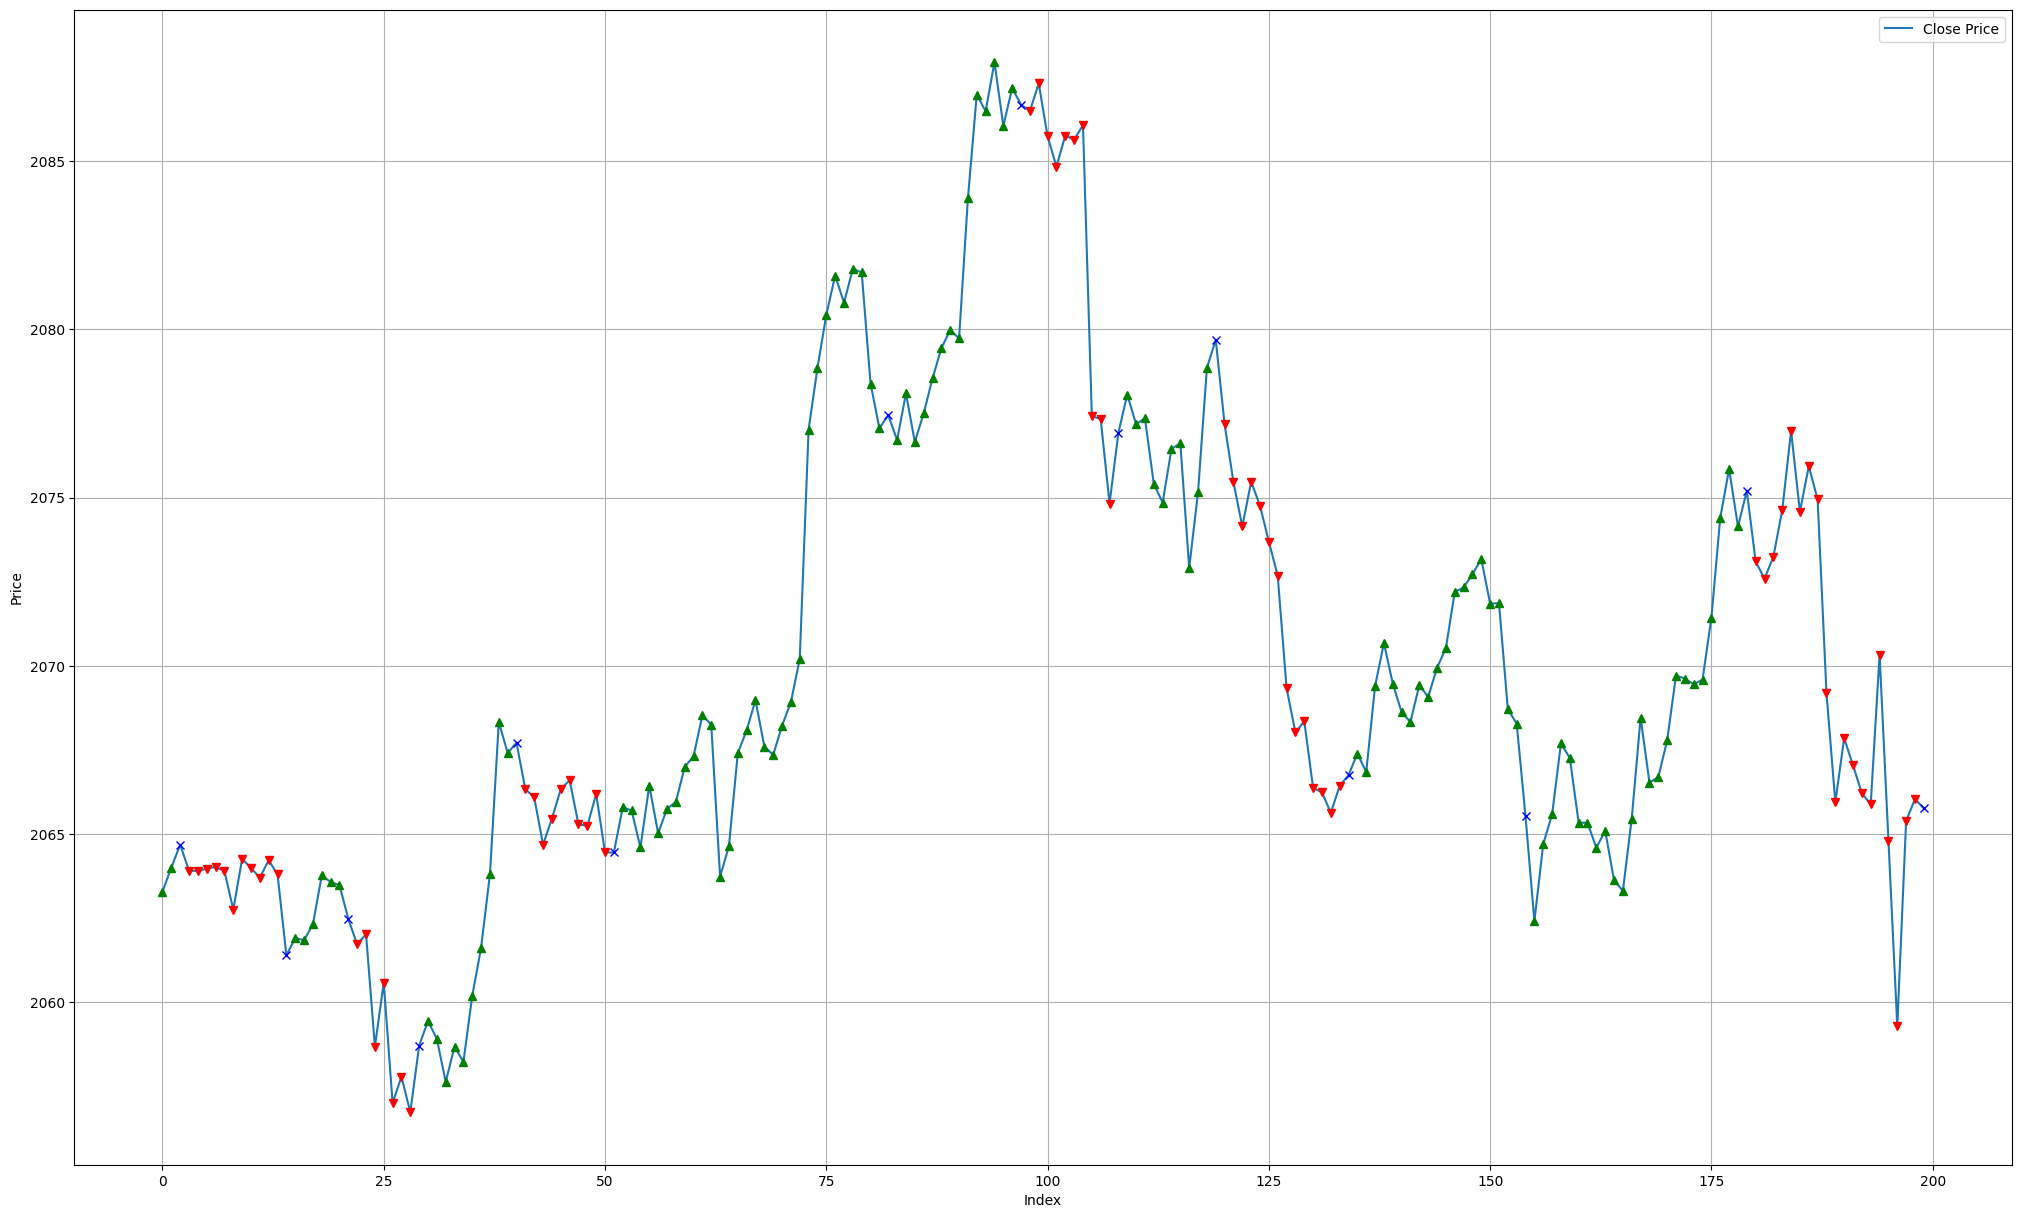

In [44]:
# Plot close price and trend signals
plt.figure(figsize=(25, 15))
plt.plot(t_cp, label='Close Price')

# Use different colors and markers for trend signals
colors = ['black', 'green', 'red','blue']
markers = [".",'^', 'v', 'x']
for i, signal in enumerate(t_s):
  plt.plot(i, t_cp[i], marker=markers[signal], color=colors[signal])

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Analyze the plot to verify the signal correctness for your specific price data.

In [45]:
print(signals[-100:])
y = signals


[2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3]


In [46]:
x_train = x[:-1000,:]
y_train = y[:-1000]

x_test = x[-1000:,:]
y_test = y[-1000:]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.008, random_state=153)
print(x_test.shape)

(1000, 5)


In [47]:
x_test = x[-1000:,:]
y_test = y[-1000:]
print(x_test[-20:])


[[ 2075.2   2073.1   2075.73  2073.09  6922.  ]
 [ 2073.1   2072.59  2074.47  2072.22  8623.  ]
 [ 2072.6   2073.24  2074.34  2071.77  7163.  ]
 [ 2073.24  2074.62  2075.55  2073.19  5936.  ]
 [ 2074.6   2076.98  2078.84  2074.54  6162.  ]
 [ 2076.98  2074.58  2077.69  2073.43  6564.  ]
 [ 2074.58  2075.93  2076.48  2074.32  5332.  ]
 [ 2075.92  2074.95  2076.1   2072.74  6719.  ]
 [ 2074.95  2069.19  2074.95  2068.2   9551.  ]
 [ 2069.19  2065.94  2069.43  2065.03  8512.  ]
 [ 2065.96  2067.85  2068.28  2065.54  7355.  ]
 [ 2067.85  2067.04  2068.7   2064.78 13183.  ]
 [ 2067.04  2066.21  2070.98  2064.85 13935.  ]
 [ 2066.2   2065.88  2067.84  2064.58 11837.  ]
 [ 2065.87  2070.33  2070.36  2062.11 24475.  ]
 [ 2070.33  2064.79  2070.63  2063.95 17931.  ]
 [ 2064.74  2059.29  2065.19  2055.82 22342.  ]
 [ 2059.28  2065.39  2067.55  2059.12 16918.  ]
 [ 2065.39  2066.04  2066.86  2064.08  8295.  ]
 [ 2066.02  2065.76  2066.89  2065.26  3181.  ]]


In [48]:
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

print(x_train)
print(x_test)

[[ 0.82687045  0.8296523   0.82459934  0.82495709  0.18975561]
 [-0.83720068 -0.83335687 -0.8367419  -0.83495665 -0.2143488 ]
 [ 0.62613682  0.62930052  0.62653933  0.62799484 -0.20045281]
 ...
 [-0.89416517 -0.90087419 -0.89385544 -0.89945206 -0.48442413]
 [-0.9017971  -0.90781843 -0.90556663 -0.90709239 -0.26545019]
 [-0.22977433 -0.23037639 -0.23380423 -0.22607037 -0.63234921]]
[[1.70877143 1.71311841 1.70949863 1.70638295 2.31673892]
 [1.7132062  1.70500533 1.70812488 1.70793167 1.55358   ]
 [1.70509297 1.71012757 1.70493092 1.7101687  1.15306164]
 ...
 [1.76934561 1.79029578 1.79130528 1.77552451 3.11441369]
 [1.79035062 1.79253032 1.78893557 1.79259481 1.18175014]
 [1.79251644 1.79156775 1.7890386  1.79665588 0.03555493]]


In [49]:
print(x.shape)
print(y.shape)

(96406, 5)
(96406,)


In [50]:
print(x_train.shape)
print(x_test.shape)

(94642, 5)
(1000, 5)


In [51]:
forest = RandomForestClassifier(n_estimators= 500,n_jobs=-1,criterion="entropy",verbose=1, random_state=52)
forest.fit(x_train,y_train)
score = forest.score(x_test, y_test)
print(score)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   39.4s


0.543


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   45.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


[1 2 1 1 1 2 1 1 1 2 2 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 2 2 2 2 1 2 2 2
 2 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2
 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 1 2 1 1 1 1 1 1 2
 2 2 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 2 2 1 2 2 1 1 2 1 2 2 2 2 2 1 2
 1 2 1 1 1 1 2 1 2 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 1 1 1 1 1
 1 1 1 2 2 1 1 2 1 1 2 2 1 1 1 2 2 2 1 1 1 1 2 2 2 2 2 2 1 2 1 1 1 1 2 1 1
 2 2 2 1 2 1 1 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

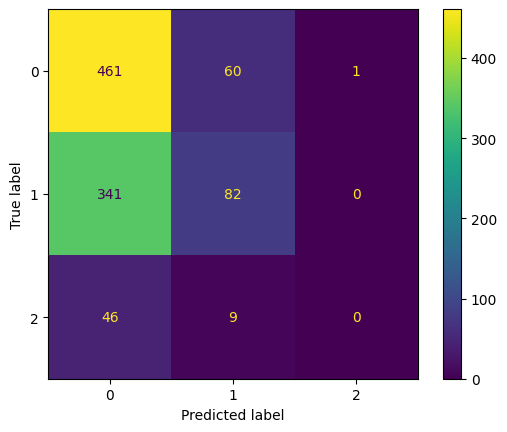

In [52]:
y_pred = forest.predict(x_test)
print(y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [53]:
closing_prices = sc.inverse_transform(x_test)
print(closing_prices)


[[ 2041.66  2042.94  2043.73  2039.03 13359.  ]
 [ 2042.95  2040.58  2043.33  2039.48  9954.  ]
 [ 2040.59  2042.07  2042.4   2040.13  8167.  ]
 ...
 [ 2059.28  2065.39  2067.55  2059.12 16918.  ]
 [ 2065.39  2066.04  2066.86  2064.08  8295.  ]
 [ 2066.02  2065.76  2066.89  2065.26  3181.  ]]


In [54]:
closing_prices = closing_prices[:,1:2]
closing_prices = closing_prices.reshape(-1)
#print(closing_prices)

In [55]:
t_cp = closing_prices[-200:]
t_s = y_pred[-200:]

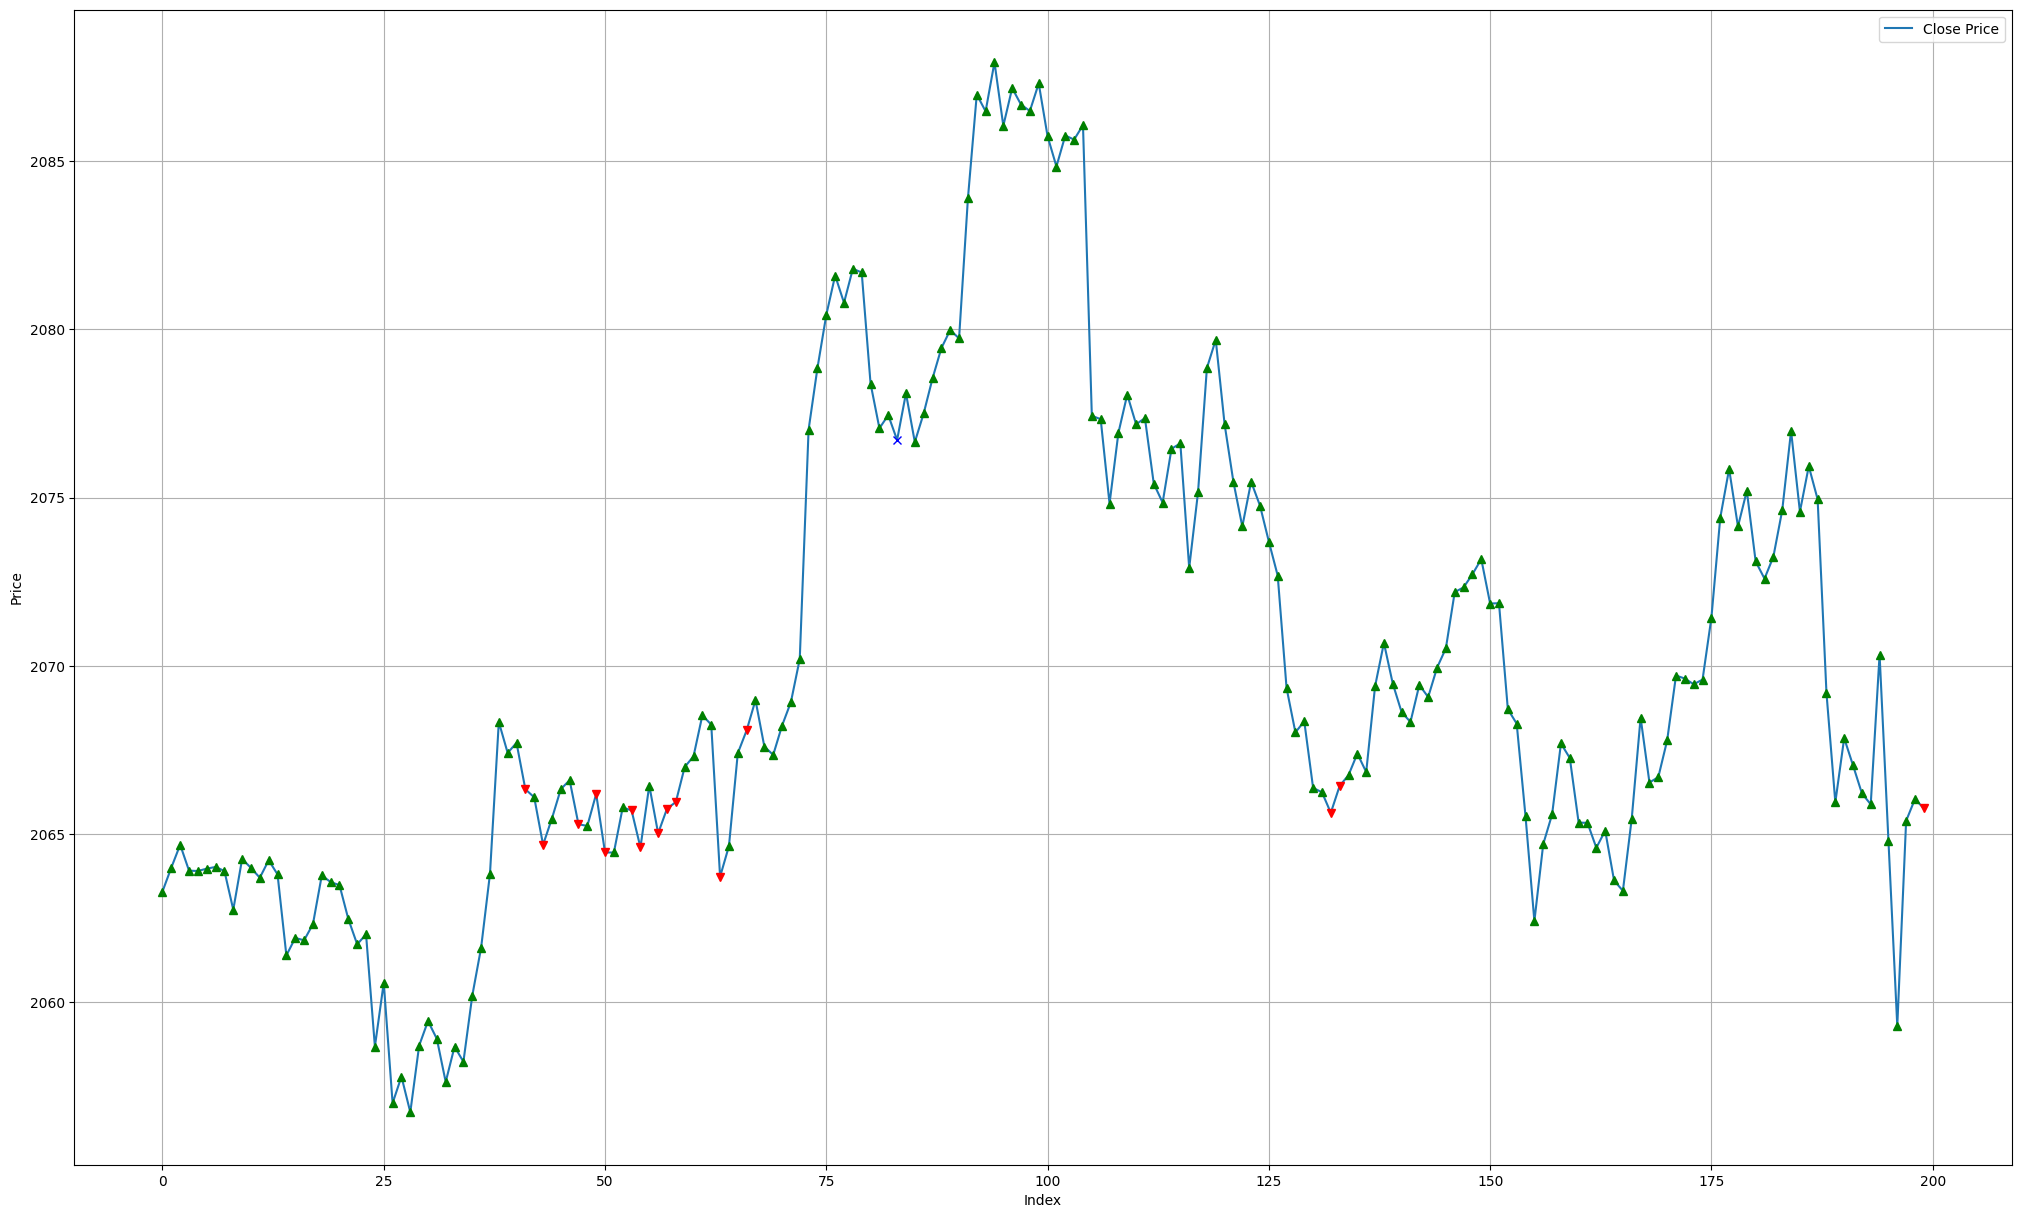

In [56]:
# Plot close price and trend signals
plt.figure(figsize=(25, 15))
plt.plot(t_cp, label='Close Price')

# Use different colors and markers for trend signals
colors = ['black', 'green', 'red','blue']
markers = [".",'^', 'v', 'x']
for i, signal in enumerate(t_s):
  plt.plot(i, t_cp[i], marker=markers[signal], color=colors[signal])

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Analyze the plot to verify the signal correctness for your specific price data.